<img src='http://linked.earth/FROGS/images/Pyrateslogo.jpg' width="400">

# PyRATES: Wavelets and Coherency

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), University of Southern California

## Preamble
Wavelets are a very broad topic in applied mathematics, which we won't attempt to summarize here. In the geoscience context, the term nearly always refers to the Continuous Wavelet Transform, and 99% of the time this uses the Morlet wavelet, which is a generalization of Fourier bases to endow them with localization in time and scale. In this tutorial we will look at the frequency content of two instrumental climate timeseries ([NINO3 and All India Rainfall](https://iridl.ldeo.columbia.edu/maproom/ENSO/Climate_Impacts/India_Rainfall.html) over time, then assess their coherence as a function of scale. The geoscience motivation is to understand at what scales, if any, [ENSO](http://www.climate.gov/enso) and the Indian Moonsoon might be related. 

### Goals

- Wavelet and coherence analysis for unevenly-spaced timeseries data
- Learning about the [Scalogram](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#scalogram-pyleoclim-scalogram) and [Coherence](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#coherence-pyleoclim-coherence) classes
- How to establish the significance of scalogram or coherence
- How to interpret the results of wavelet and wavelet coherence analyses 

**Reading Time: 20 min**

### Keywords
Wavelet Analysis, Wavelet Transform Coherency, Visualization 

### Pre-requisites
Some timeseries analysis, ideally 

### Relevant Packages
pyleoclim, pandas, matplotlib, numpy

## Data description

- NINO3
- AIR

Let us first load necessary packages:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyleoclim as pyleo
import numpy as np

## Data Wrangling

The datasets already ship with `Pyleoclim`, making loading a breeze:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'ENSO vs Indian Moosoon'}, xlabel='Time [year C.E.]', ylabel='value'>)

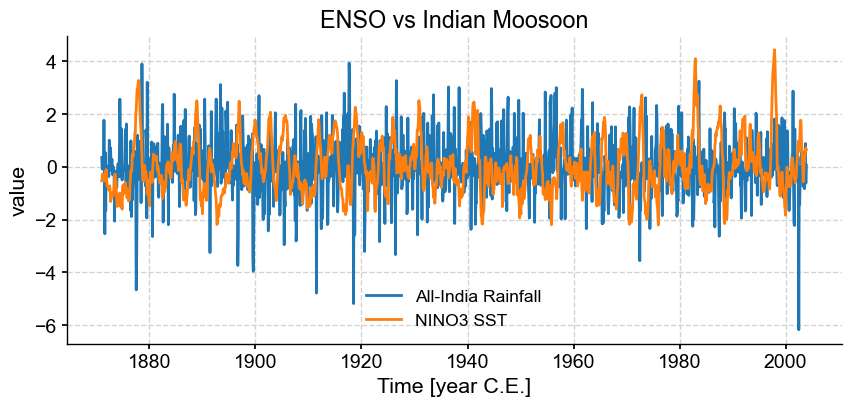

In [5]:
nino3 = pyleo.utils.load_dataset('NINO3')
air = pyleo.utils.load_dataset('AIR')
ms = air & nino3
ms.label = 'ENSO vs Indian Moosoon'
ms.standardize().plot()

At first glance there isn't anything terribly obvious about how these two variables might relate. Precipitation is generally a noisier variable than sea-surface temperature, displaying much more short-term variability. To see this, let's look at the spectra of these two series.

## Spectral Analysis


Performing spectral analysis on individual series: 100%|██████████| 10/10 [00:00<00:00, 19.16it/s]
Performing spectral analysis on individual series: 100%|██████████| 10/10 [00:00<00:00, 20.38it/s]


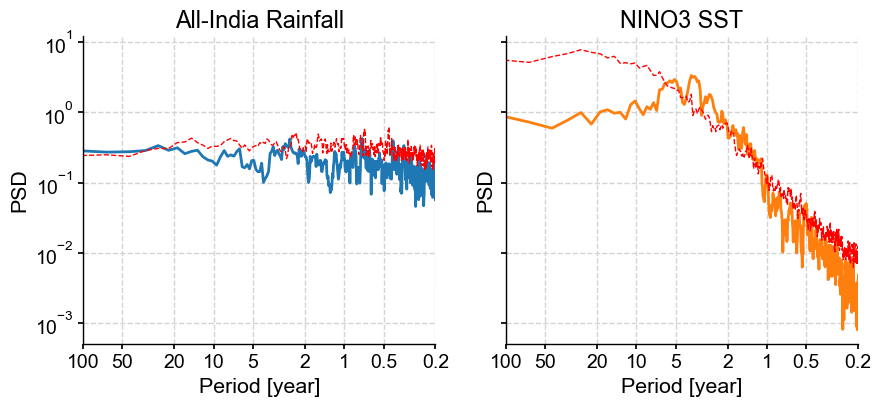

In [16]:
fig, axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
axs.flatten()
for i, ts in enumerate(ms.series_list):
    psd = ts.spectral(method='mtm')
    psds = psd.signif_test(number=10)
    psds.plot(ax=axs[i], color=colors[i],legend=False,
             title=ts.label)

Indeed the two series have different frequency content. All India rainfall has a very flat spectrum, difficult to distinguish from noise (as a tested by the similarities to the AR(1) benchmark). On the other hand, the NINO3 spectrum displays much more low frequency content, with  peaks that poke above the AR(1) background. 

On its own, this tells us very little about areas of overlap between these signals; for this, we need another tool (coherence). In addition, there is one major drawback of spectral analysis: it assumes that timeseries are stationary, i.e. that the frequency content is the same throughout the entire length of the record. In nonlinear timeseries like those (and many other geophysical timeseries), this is rarely the case. Instead

## Musical Interlude

Even if you are not a musician, you've likely seen sheet music like this before:

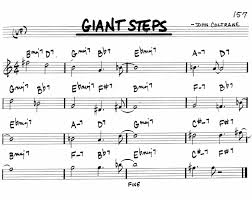

This one is a representation of the notes that get played as part of John Coltrane's masterpiece, [Giant Steps](https://www.youtube.com/watch?v=rh6WTAHKYTc). To do that, sheet music has to convey what notes (pitch, i.e. frequency) are played at what time, so the object is two-dimensional: a linear time axis (going from left to right here) and a frequency axis (going from low to high: low notes hang on the low ledger lines, and vice versa for the high notes. If we want a system to represent how the frequency content of a timeseries varies as time goes by, this would be a good choice.


## Wavelet Analysis

As explained in the [notes](URL TBD), this is exactly what wavelet analysis does. The functions used to analize the signal are oscillatory (like sines and cosines), with this crucial difference that instead of extending out to infinity, the are localized to a relatively small portion of the timeseries, and can be stretched out and compressed while preserving their shape. This allows to "unfold" a spectrum and look at its evolution over time. There are several ways to access that functionality in Pyleoclim, but here we use `summary_plot`, which stacks together the timeseries itself, its scalogram (a plot of the magnitude of the wavelet power), and the power spectral density (PSD) obtained from summing the wavelet coefficients over time. 

In [17]:
scal = nino3.wavelet()

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'NINO3 SST scalogram (CWT)'}, xlabel='Time [year C.E.]', ylabel='Scale [yrs]'>)

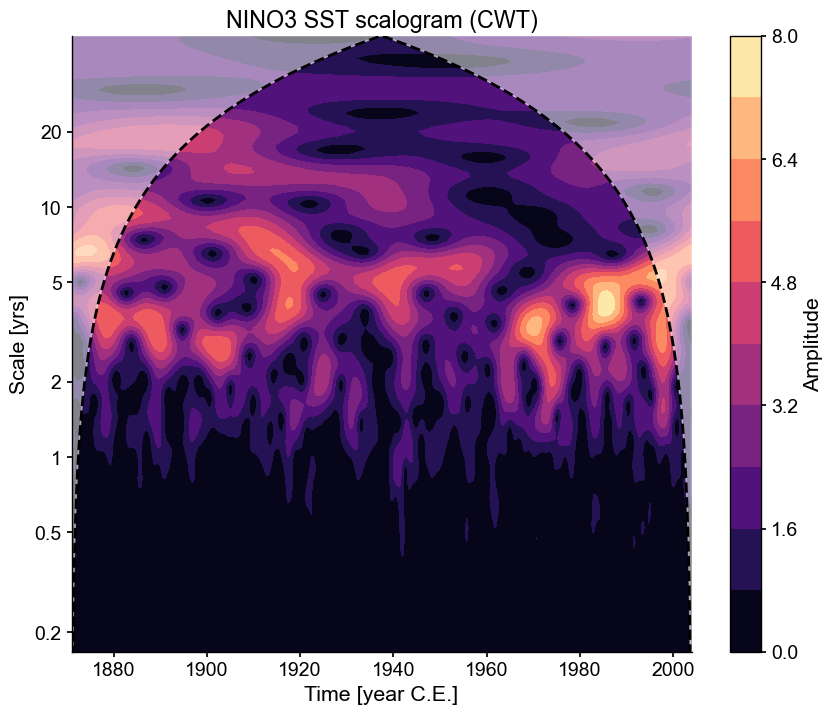

In [18]:
scal.plot()

Just like sheet music, the scalogram reveals how spectral power (technically, wavelet power) changes over time: you can read time off the x axis, and pitch (here, scale, which is closely related) on the y axis. Islands of high amplitude show you what scales of oscillation are prominent at given points in time.  

But which aspects of this are significant? There are two ways to test this in `pyleoclim`, both using an AR(1) benchmark. The first uses a parametric, asymptotic form of the theoretical spectrum of an AR(1) process:

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'NINO3 SST scalogram (CWT) with 95% threshold'}, xlabel='Time [year C.E.]', ylabel='Scale [yrs]'>)

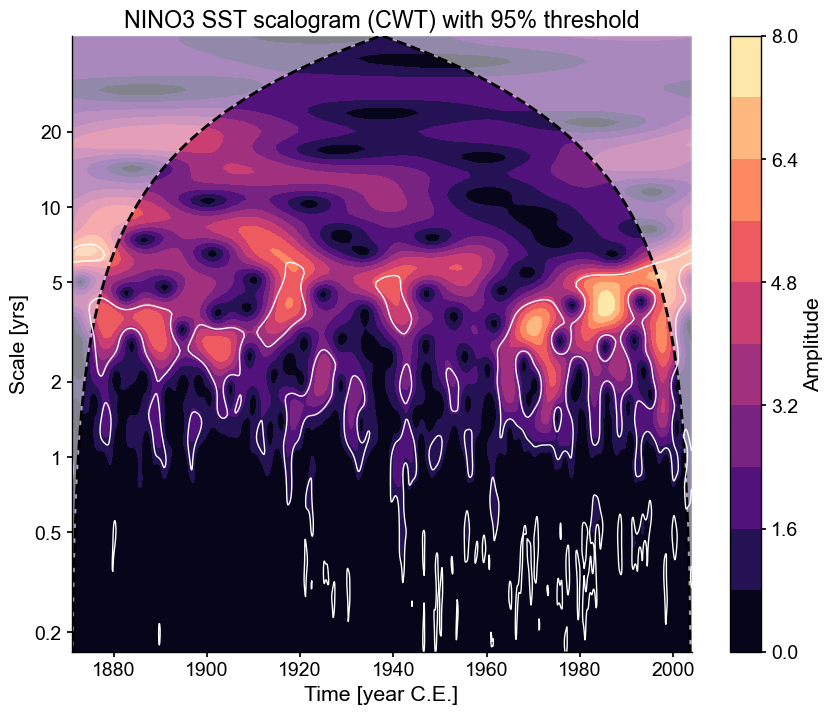

In [19]:
scal_sig = scal.signif_test(method='ar1asym')
scal_sig.plot()

The white lines delineate regions of the scalogram that are significant against an AR(1) benchmark, thus encircling "islands" of notable power. We see that the quasi-biennial (2y) periodicity is particularly pronounced in the early part of the record, but after the 1970's the period appears to lengthen. We also see a lulll in interannual variability between the 40's and 60s.  

Now, notice that we specified the method 'ar1asym' for the asssessment of significance; this tells the code to use an asymptotic approximation to the distribution of the AR(1) benchmarks, making it lightning-fast. We could also have used direct simulation (the default method), and indeed this would yield a very similar result, albeit more slowly: 

Performing wavelet analysis on individual series: 100%|██████████| 1000/1000 [00:15<00:00, 63.68it/s]


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'NINO3 SST scalogram (CWT) with 95% threshold'}, xlabel='Time [year C.E.]', ylabel='Scale [yrs]'>)

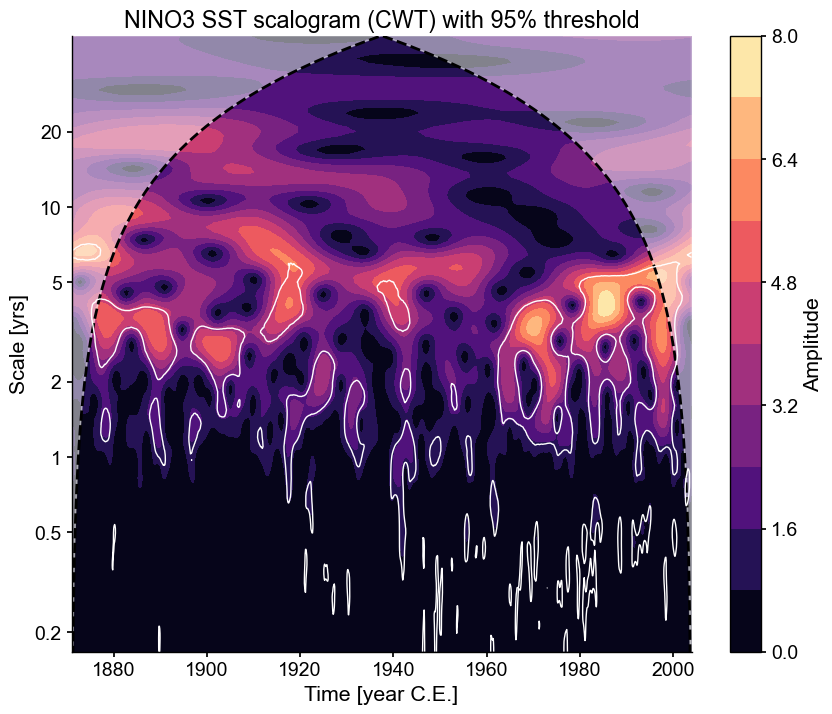

In [20]:
scal_sig2 = scal.signif_test(method='ar1sim', number = 1000)
scal_sig2.plot()

To better match up the features of the scalogram and those of the timeseries' trace, let's use the [summary_plot()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.summary_plot) method. To speed things up, we'll actually pass it the scalogram significance estimate just computed:

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Time [year C.E.]', ylabel='NINO3 [$^{\\circ}$C]'>,
  'scal': <Axes: xlabel='Time [year C.E.]', ylabel='Scale [yrs]'>,
  'psd': <Axes: xlabel='mtm PSD'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

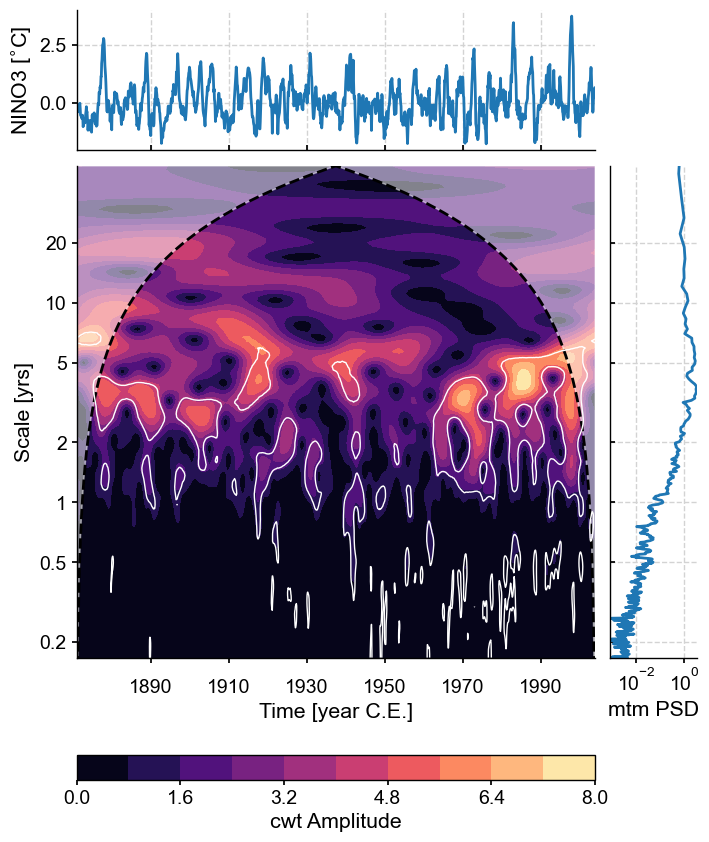

In [22]:
nino3.summary_plot(psd=psd,scalogram=scal_sig2)

In a sense, the spectrum on the right is what you would get if you would average the scalogram values over time (it is not exactly so because the estimators used for the scalogram and the spectrum are slightly different, but this is a way to think about it conceptually). 

Now we can better see how the broadband interannual peak glimpsed earlier in the spectrum figure is really the juxtaposition of several oscillations with a shifting frequency over time. It would have been impossible to know this with just the spectrum. 

Performing wavelet analysis on individual series: 100%|██████████| 1000/1000 [00:15<00:00, 65.32it/s]


(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Time [year C.E.]', ylabel='AIR [mm/month]'>,
  'scal': <Axes: xlabel='Time [year C.E.]', ylabel='Scale [yrs]'>,
  'psd': <Axes: xlabel='mtm PSD'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

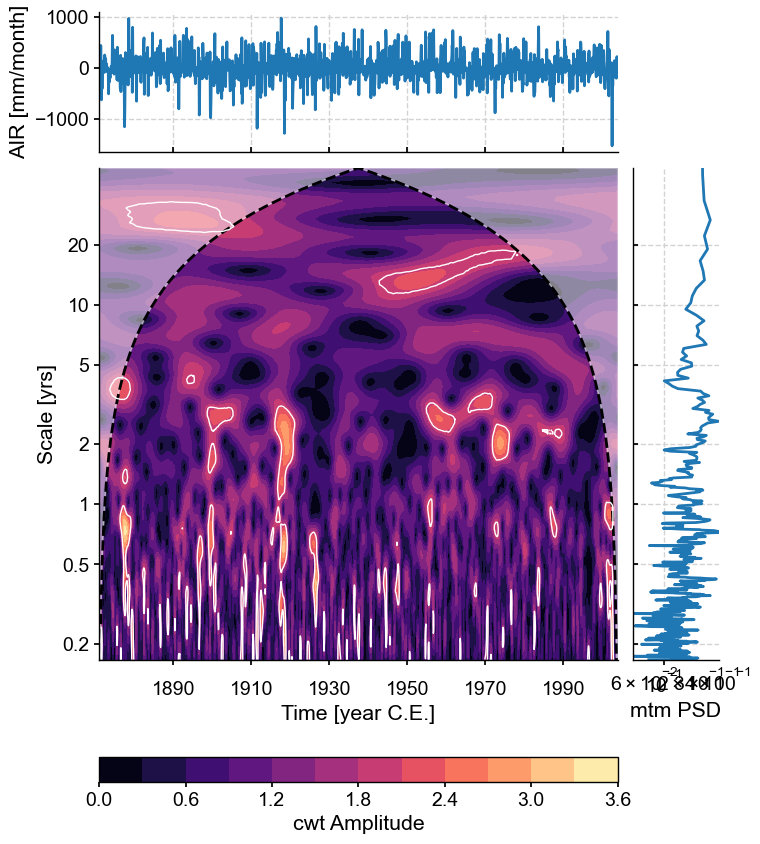

In [24]:
air_psd = air.spectral(method='mtm')
air_scal = air.wavelet().signif_test(number=1000)
air.summary_plot(psd = air_psd, scalogram=air_scal)

##  NINO3 vs AIR

Now let us delve into the relationship between NINO3 and AIR. To do that, we apply [wavelet transform coherency](https://hal.archives-ouvertes.fr/hal-00302394/) to identify phase relationships between the two series at various scales:

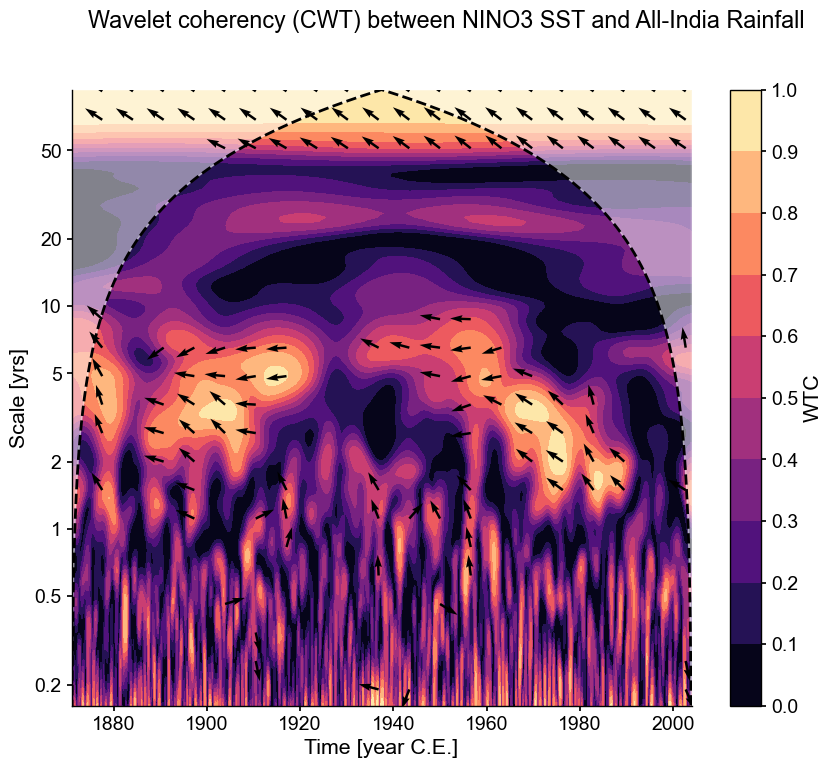

In [25]:
coh = nino3.wavelet_coherence(air)
fig, ax = coh.plot()

This plot shows two things:
- the **wavelet transform coherency (WTC)**, which may be thought of as a (squared) correlation coefficient in time-scale space: 0 if the series do not covary, 1 if they vary in perfect unison at that time and scale. 
- the **phase angle** between the two series, as arrows using a trigonometric convention (right = 0, top = 90 degrees, left = 180 degrees, bottom = -90 or + 270 degrees).

Arrows pointing to the right indicate a phase angle close to zero at all scales longer than precession. We can quantify that by computing the average phase angle in a given range of scales, like so:

In [30]:
ph = coh.phase_stats(scales=[2,8])
print("The mean angle is {:4.2f}°".format(ph.mean_angle/np.pi*180))

The result is compatible with an anti-phased relationship between ENSO and the Indian Monsoon on internnual timescales, perhaps with a small lag. For instance, we are $26^{\circ}$ away from $180^{\circ}$. For a 4y scale, $360^{\circ}$ would be 4 years, so $26^{\circ}$ is:

In [34]:
26/360*4*12

3.4666666666666663

About 3.5 months. 

One might be tempted to interpret phase angles at shorter scales. Let us first see if they are significant against AR(1) benchmarks. As before this can be done in one function call, though some patience is required to obtain the result. 

In [35]:
coh_sig = coh.signif_test(number=100)
phase = coh_sig.phase_stats(scales=[2,8])

Performing wavelet coherence on surrogate pairs: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


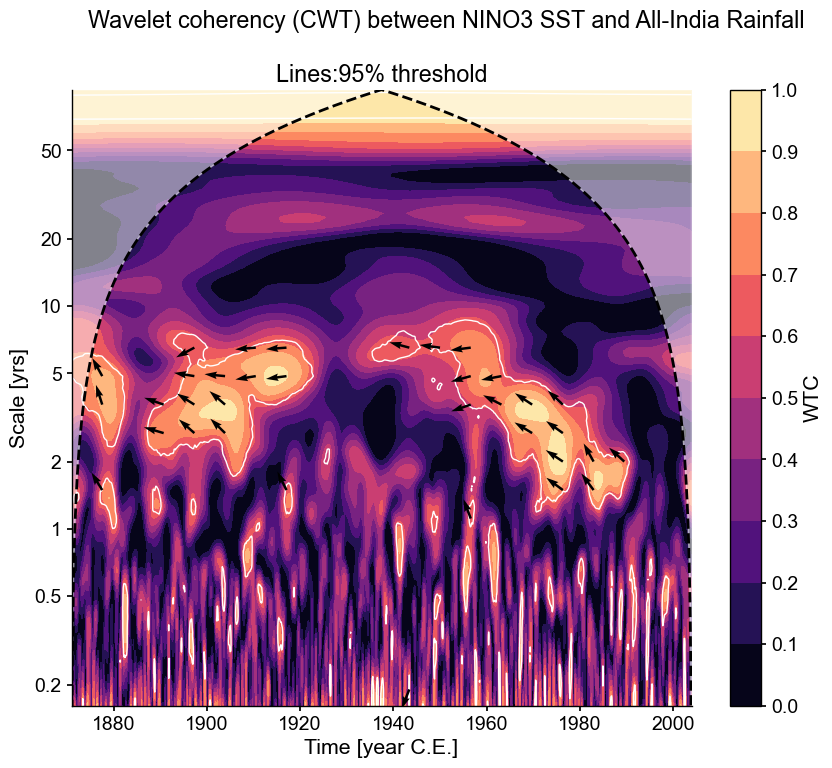

In [38]:
fig, ax = coh_sig.plot()

We see indeed that very few of the arrows at scales shorter than 2y are associated with any signicant "islands". Note that `Pyleoclim` 
Let us return to the estimate of the phase:

In [36]:
print(phase)

Results(mean_angle=2.6927825175802447, kappa=3.360315074427689, sigma=0.6012824554612396, kappa_hi=0.4933347992598349, sigma_lo=1.6907488549753198)


The result contains `mean_angle` (the mean angle for those scales), `sigma` (the circular standard deviation of the angles), `kappa` (the von Mises statistic), `sigma_lo` (alpha-level quantile for sigma) and `kappa_hi`, the (1-alpha)-level quantile for `kappa`.  $\kappa$ is a measure of concentration (a reciprocal measure of dispersion), so $1/\kappa$ is analogous to $\sigma^2$. For a phase relationship to be coherent, it should have a consistent angle throughout, so low $\sigma$, high $\kappa$. The confidence limits are given as `sigma_lo` and `kappa_hi`

From this example, one diagnoses a strong anti-phased relationship in the ENSO band, with high von Mises concentration ($\kappa \sim 3.36 \gg \kappa_{hi} = 0.49$) and low circular dispersion ($\sigma \simeq 0.5 \ll \sigma_{lo}=1.69$). This would be strong evidence of a consistent anti-phasing between NINO3 and AIR at those scales. That is, El Niño events tend to depress Indian Monsoon rainfall, as was observed 

Another consideration is that coherency is like the correlation coefficient in wavelet space: it tells you how similar two series are for a given time and scale, yet it says nothing about what fraction of the total variability is shared. This is better measured by the cross-wavelet transform (XWT), which highlights areas of high common power. Both of those, along with the original series, can be visualized with one swift function call:

(<Figure size 900x1200 with 6 Axes>,
 {'ts1': <Axes: ylabel='NINO3 [$^{\\circ}$C]'>,
  'ts2': <Axes: xlabel='Time [year C.E.]', ylabel='AIR [mm/month]'>,
  'wtc': <Axes: ylabel='Scale [yrs]'>,
  'xwt': <Axes: xlabel='Time [year C.E.]', ylabel='Scale [yrs]'>})

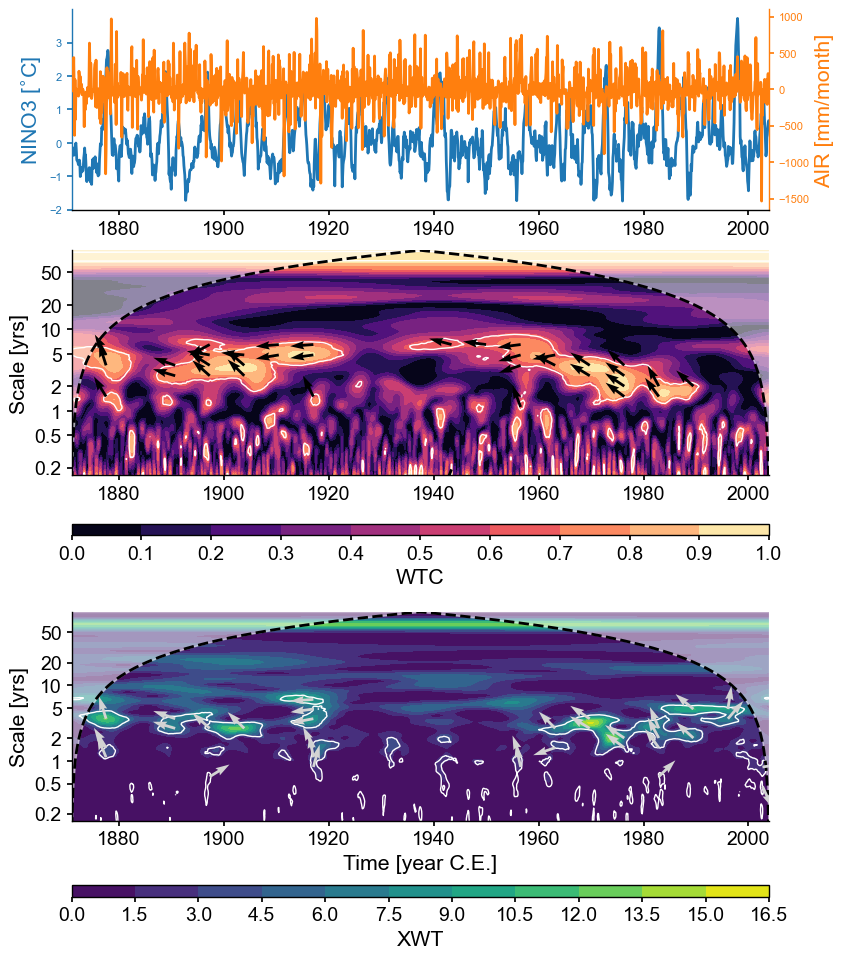

In [39]:
coh_sig.dashboard()

Here we see that the interannual scales are the only ones to show up consistently throughout both metrics (XWT and WTC). This means that, out of the large swathes of WTC one would consider "coherent", only those areas highlighted in XWT in green-yellow are likely important.  


## Takeways

- `Pyleoclim` enables wavelet and wavelet coherence analysis. 
- evenly-spaced data are handled with the CWT algorithm of [Torrence & Compo (1998)](https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2), which is very fast; unevenly-spaced data are handled through the WWZ algorithm of [Foster (1996)](https://adsabs.harvard.edu/full/1996AJ....112.1709F), which is slow. 
- Both [Scalogram](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#scalogram-pyleoclim-scalogram) and [Coherence](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#coherence-pyleoclim-coherence) objects have a built-in `signif_test()` method, which the `plot()` method will know what to do with. 
- Wavelet Transform Coherency may be thought of as a (squared) correlation coefficient in time-scale space: 0 if the series do not covary, 1 if they vary in perfect unison at that time and scale. 
- Properly interpreting the results of wavelet and wavelet coherence analyses requires knowing something about the methods. Theory helps!